## I. Обкачиваем датасет из Google Картинок

In [ ]:
'''

Для обкачки датасета используется библиотека google_images_download

Установка из репозитория в папке

Через несколько поисковых обкачек собрал датасет из ~300-350 картинок на каждое время года

'''

In [ ]:
from google_images_download import google_images_download 
  
response = google_images_download.googleimagesdownload() 
  
search_queries = [
    'winter landscape photo wallpaper', 
    'spring landscape photo wallpaper', 
    'summer landscape photo wallpaper', 
    'autumn landscape photo wallpaper'
]
    
def downloadimages(query):
    arguments = {"keywords": query,
                 "format": "jpg",
                 "limit": 100,
                 "print_urls":True,
                 "size": "medium",
                 "aspect_ratio":"panoramic"}
    try:
        response.download(arguments)
      
    # Handling File NotFound Error    
    except FileNotFoundError: 
        arguments = {"keywords": query,
                     "format": "jpg",
                     "limit":10,
                     "print_urls":True, 
                     "size": "medium"}
                       
        # Providing arguments for the searched query
        try:
            # Downloading the photos based
            # on the given arguments
            response.download(arguments) 
        except:
            pass

for query in search_queries:
    downloadimages(query) 
    print() 

In [ ]:
# разбиваем на train/test
import os
import cv2
import numpy as np
import random
import shutil

dirs = [
    './landscapes_dataset/winter/', 
    './landscapes_dataset/spring/', 
    './landscapes_dataset/summer/', 
    './landscapes_dataset/autumn/'
]



for dataset_dir in dirs:
    files = os.listdir(dataset_dir)
    _, dataset_name, season, _ = dataset_dir.split('/')
    random.shuffle(files)
    train, test = np.split(files, [int(len(files)*0.9)])
    
    os.makedirs(dataset_name+'/train/'+season)
    for file in train:
        img = cv2.imread(dataset_dir+file)
        img = np.full(img.shape, img, dtype=np.float32)
        cv2.imwrite(dataset_dir+file, img)
        shutil.copy(dataset_dir+file, dataset_name+'/train/'+season)
        
    os.makedirs(dataset_name+'/test/'+season)
    for file in test:
        img = cv2.imread(dataset_dir+file)
        img = np.full(img.shape, img, dtype=np.float32)
        cv2.imwrite(dataset_dir+file, img)
        shutil.copy(dataset_dir+file, dataset_name+'/test/'+season)

## II. Fine-tuning

In [ ]:
'''

Скачиваем предобученную на ImageNet модель, после чего заморозим часть слоев, а оставшиеся подтюним на нашу задачу

В качестве модели взял легкую сетку ResNet34 

'''

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [47]:
data_dir = "./landscapes_dataset/"

model_name = "resnet"

num_classes = 4

batch_size = 128

num_epochs = 100

feature_extract = True

In [49]:
# Data augmentation and normalization for training
# Just normalization for validation

input_size = [224,224]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.abspath(os.path.join(data_dir, x)), data_transforms[x]) for x in ['train', 'test']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [27]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
def set_parameter_requires_grad(model, feature_extracting, last_layers_to_unfreeze):
    if feature_extracting:
        for param in list(model.parameters())[:-last_layers_to_unfreeze]:
            param.requires_grad = False

In [62]:
model_ft = models.resnet34(pretrained=True).to(device)

# размораживаем 8 последних слоев, т.к. остаются 2 полноценных сверточных слоя + батч норм + классификатор
set_parameter_requires_grad(model_ft, feature_extract, 8)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-5)

Params to learn:
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 fc.weight
	 fc.bias


In [16]:
torch.multiprocessing.freeze_support()

In [63]:
criterion = nn.CrossEntropyLoss()

model_ft = model_ft.to(device)

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 1.6472 Acc: 0.2367
test Loss: 1.4884 Acc: 0.2910

Epoch 1/99
----------
train Loss: 1.4485 Acc: 0.3145
test Loss: 1.3464 Acc: 0.3806

Epoch 2/99
----------
train Loss: 1.3107 Acc: 0.3922
test Loss: 1.2132 Acc: 0.4403

Epoch 3/99
----------
train Loss: 1.1976 Acc: 0.4911
test Loss: 1.1124 Acc: 0.4925

Epoch 4/99
----------
train Loss: 1.0971 Acc: 0.5613
test Loss: 1.0265 Acc: 0.5821

Epoch 5/99
----------
train Loss: 1.0178 Acc: 0.6281
test Loss: 0.9557 Acc: 0.6716

Epoch 6/99
----------
train Loss: 0.9545 Acc: 0.6484
test Loss: 0.9030 Acc: 0.7239

Epoch 7/99
----------
train Loss: 0.9074 Acc: 0.6847
test Loss: 0.8521 Acc: 0.7388

Epoch 8/99
----------
train Loss: 0.8709 Acc: 0.6932
test Loss: 0.8077 Acc: 0.7537

Epoch 9/99
----------
train Loss: 0.8254 Acc: 0.7194
test Loss: 0.7777 Acc: 0.7836

Epoch 10/99
----------
train Loss: 0.7875 Acc: 0.7371
test Loss: 0.7482 Acc: 0.7910

Epoch 11/99
----------
train Loss: 0.7442 Acc: 0.7574
test Loss: 0.7213 Acc

test Loss: 0.5345 Acc: 0.7910

Epoch 97/99
----------
train Loss: 0.2582 Acc: 0.9214
test Loss: 0.5278 Acc: 0.8134

Epoch 98/99
----------
train Loss: 0.2675 Acc: 0.9138
test Loss: 0.5356 Acc: 0.8060

Epoch 99/99
----------
train Loss: 0.2603 Acc: 0.9163
test Loss: 0.5239 Acc: 0.7985

Training complete in 5m 48s
Best val Acc: 0.835821


In [67]:
torch.save(model_ft, "./resnet34_landscapes_classification.h5")

In [86]:
model_ft = torch.load("./resnet34_landscapes_classification.h5")

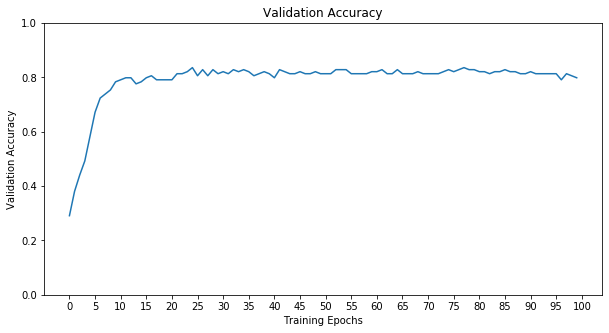

In [169]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

line, = ax.plot(range(0, num_epochs), ohist)


plt.title("Validation Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs+1, 5.0))


ax.set_ylim(0,1)
plt.show()

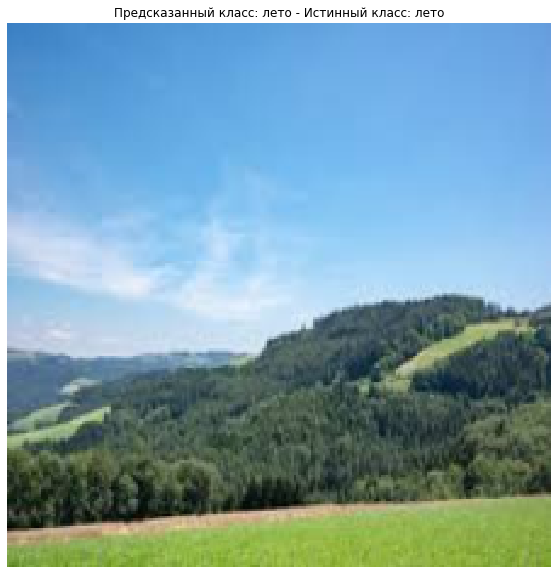

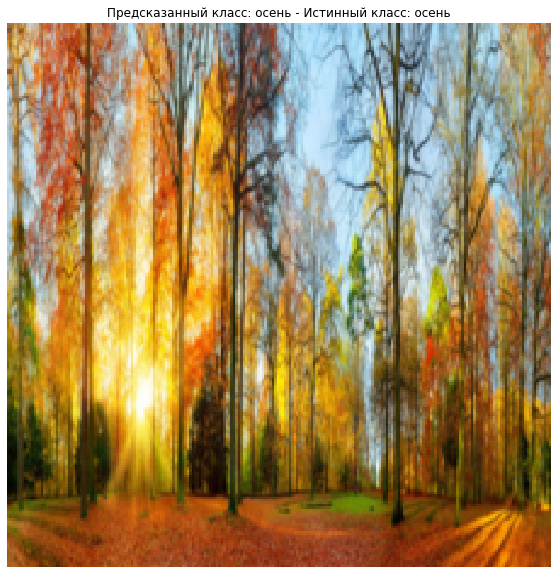

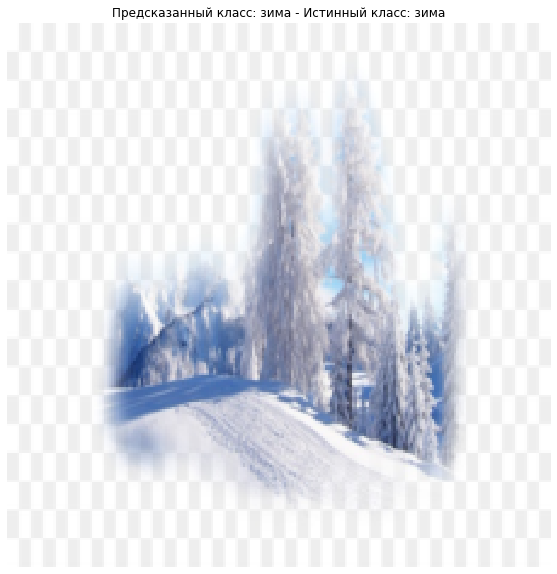

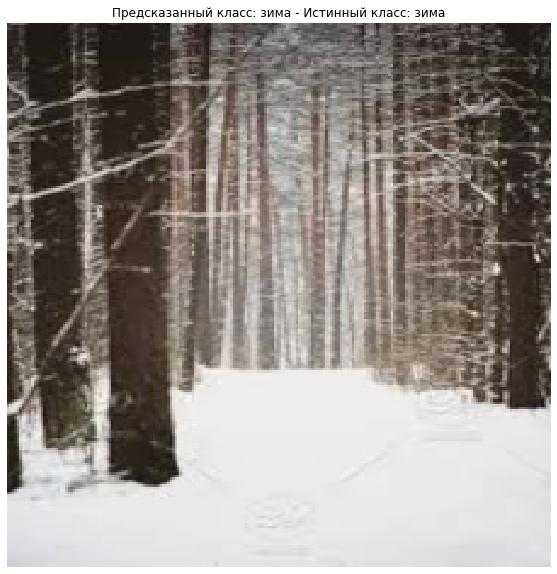

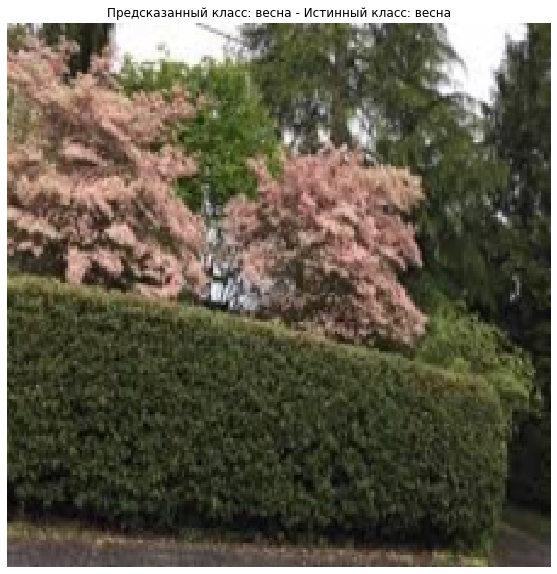

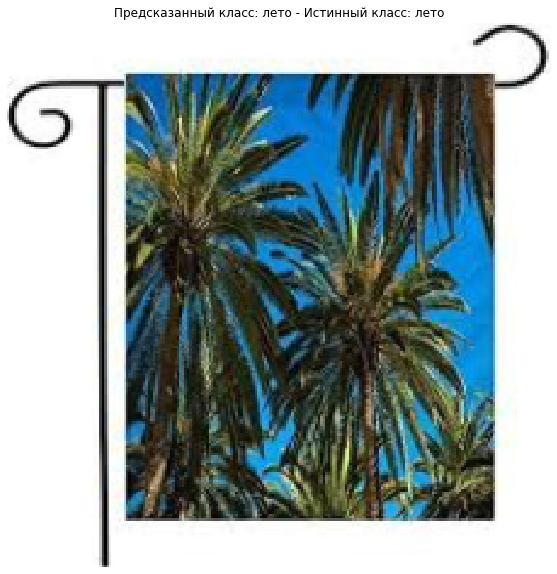

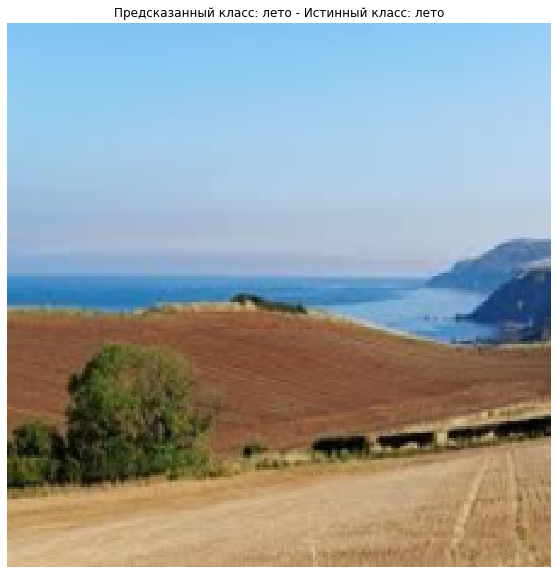

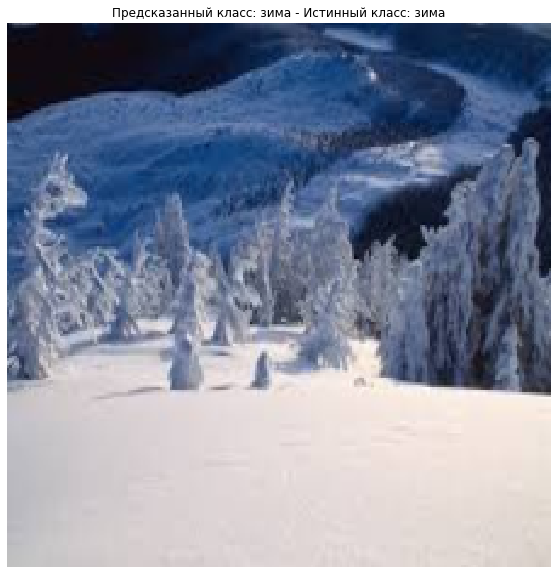

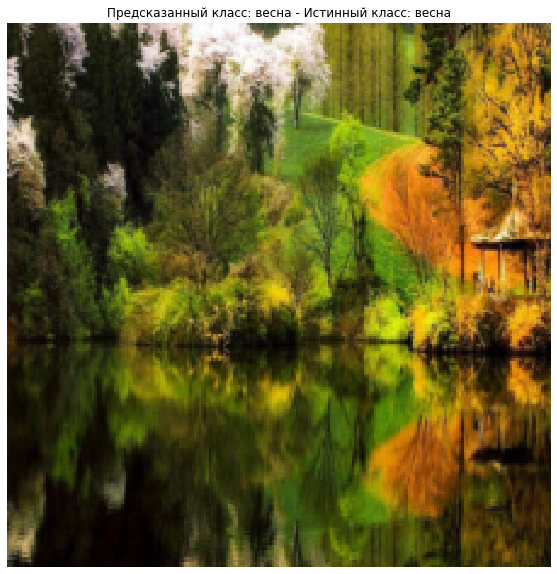

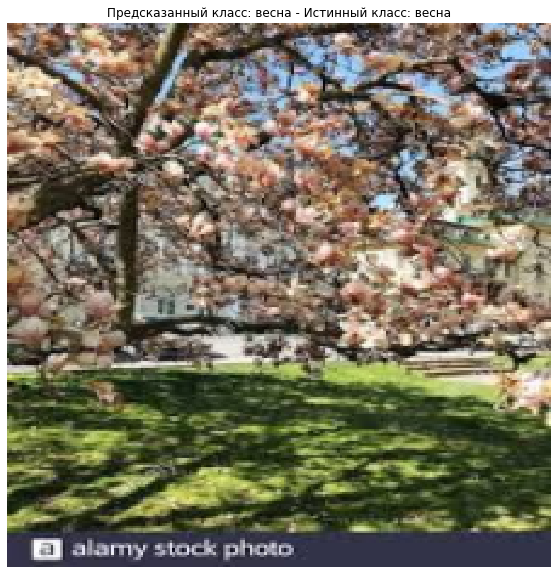

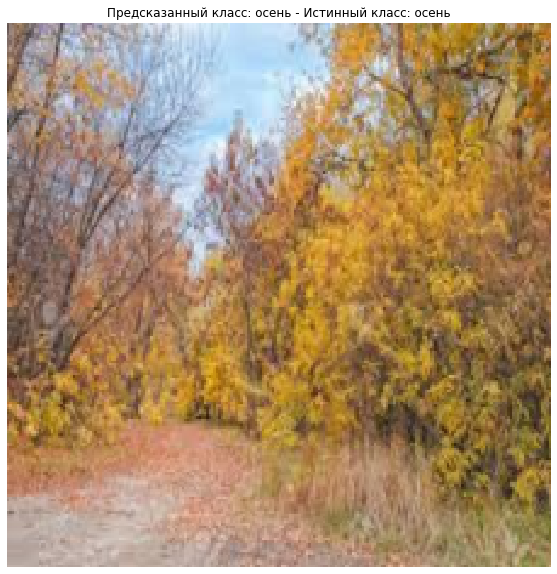

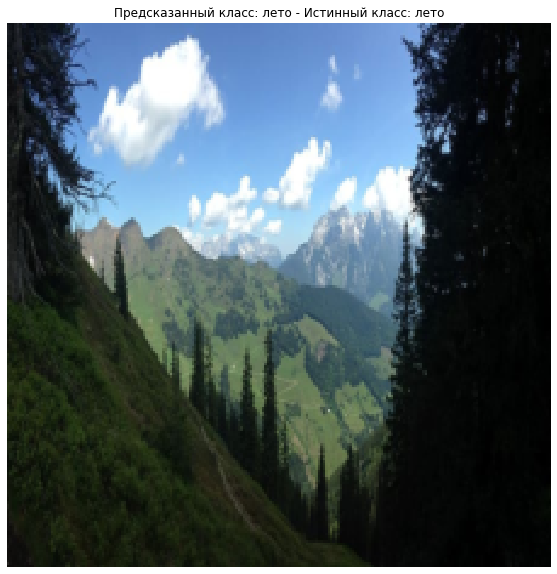

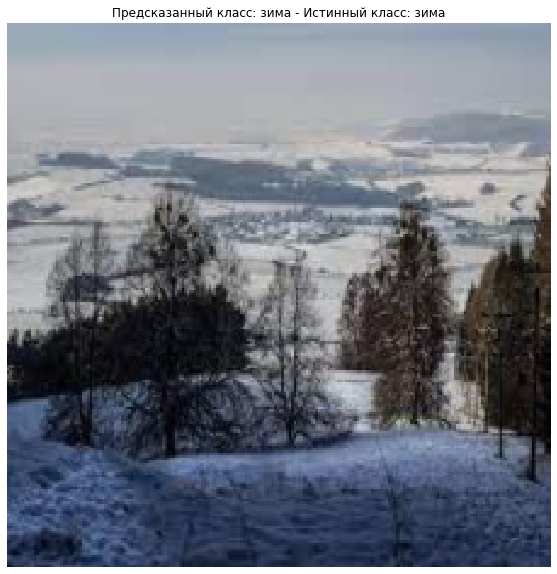

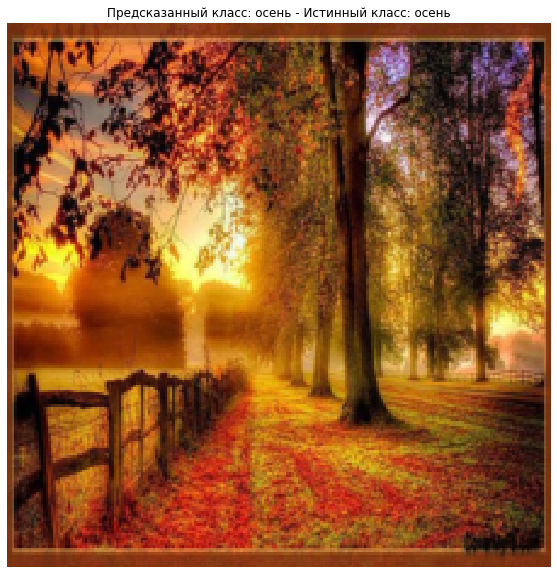

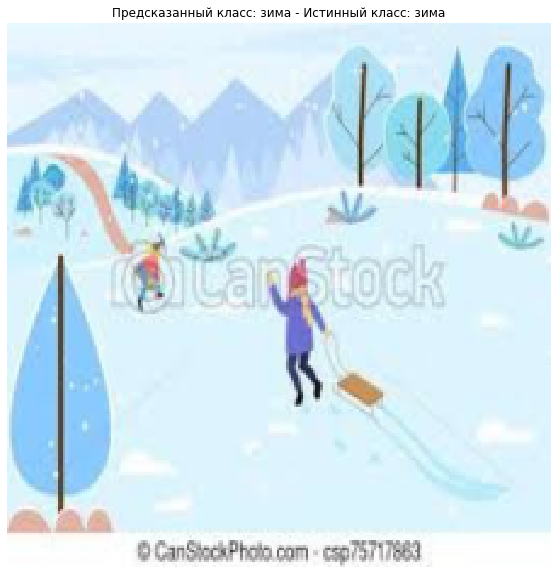

In [85]:
classes = {
    0 : "осень",
    1 : "весна", 
    2 : "лето",
    3 : "зима"
}

model_ft.eval()

val_data, val_labels = next(iter(dataloaders_dict['test']))
val_data = val_data.to(device)
out = model_ft(val_data)
_, scores = torch.max(out, axis=1)


for i in range(15):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.title(f"Предсказанный класс: {classes[scores[i].item()]} - Истинный класс: {classes[val_labels[i].item()]}")
    plt.imshow(np.transpose(val_data[i].cpu(), [1,2,0]))

## Random photos check

In [208]:
# Проверим работу модели на 4 рандомных картинки из интернета
val_image_dataset = datasets.ImageFolder(os.path.abspath(os.path.join(data_dir, 'val')), data_transforms['test'])
val_dataloader = torch.utils.data.DataLoader(val_image_dataset, batch_size=4, shuffle=True, num_workers=4)

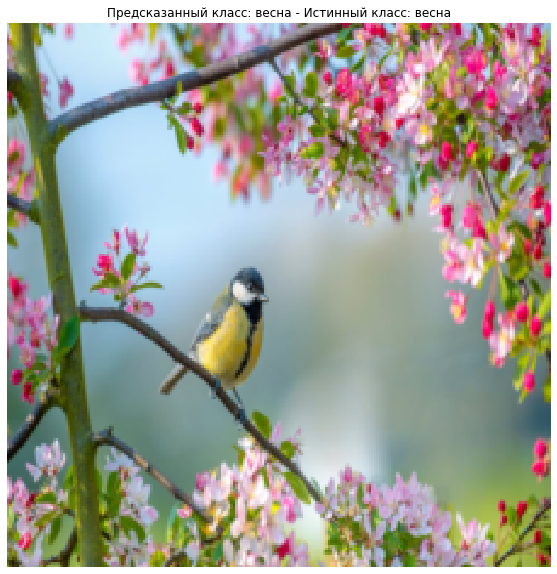

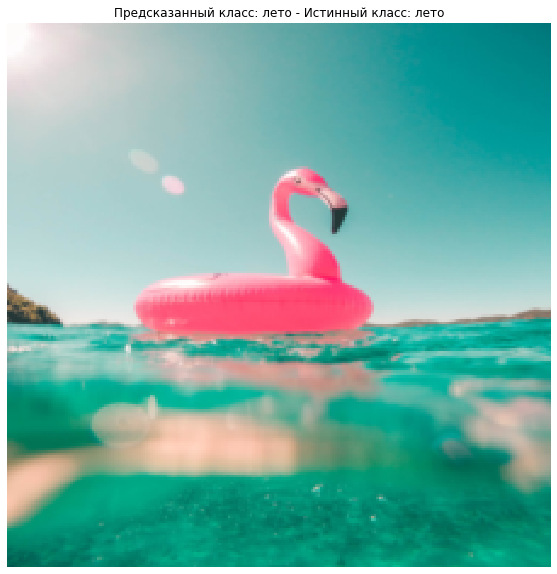

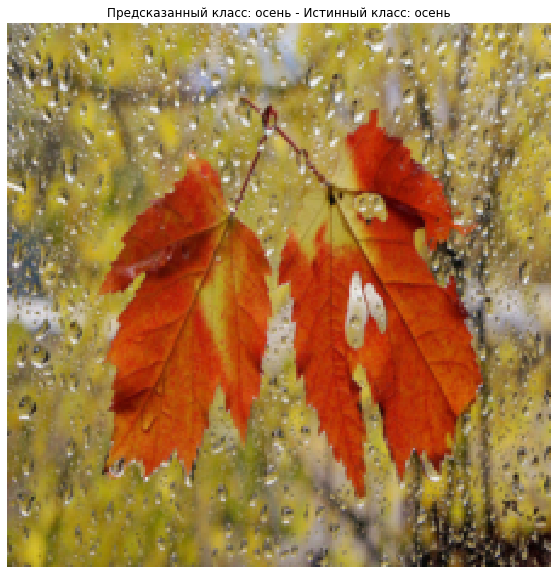

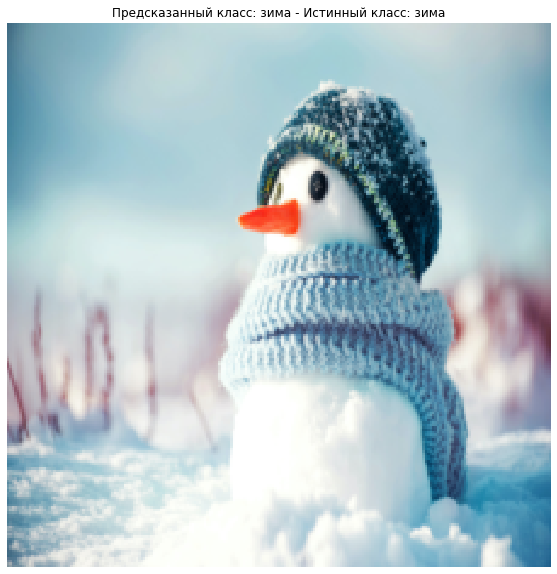

In [209]:
classes = {
    0 : "осень",
    1 : "весна", 
    2 : "лето",
    3 : "зима"
}

model_ft.eval()

val_data, val_labels = next(iter(val_dataloader))
val_data = val_data.to(device)
out = model_ft(val_data)
_, scores = torch.max(out, axis=1)


for i in range(4):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.title(f"Предсказанный класс: {classes[scores[i].item()]} - Истинный класс: {classes[val_labels[i].item()-1]}")
    plt.imshow(np.transpose(val_data[i].cpu(), [1,2,0]))